
 Data Overview & Structure Analysis
Credit Risk Modeling for Bati Bank

Project: Buy-Now-Pay-Later Credit Scoring Model  
Dataset:Xente eCommerce Transactions  
Rows: 95,662 transactions  
Columns: 16 features + 5 engineered temporal features

 Executive Summary
 This notebook provides a comprehensive overview of the e-commerce transaction data that will be used to develop a credit risk model for Bati Bank's new buy-now-pay-later service.


1. Import Libraries & Setup

In [1]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

In [2]:
# %%
# Bank-specific styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
bank_colors = ['#003366', '#0066CC', '#0099FF', '#00CCFF', '#66CCFF']  # Corporate blue theme

# Configure display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully



 2. Load Cleaned Data

In [3]:
# %%
print("📂 Loading cleaned data from EDA pipeline...")

# Load the cleaned data - use the correct path that was verified
df = pd.read_csv('../../data/processed/cleaned_data.csv', parse_dates=['TransactionStartTime'])

# Display basic information
print(f"📊 Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"💾 Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"📅 Time Range: {df['TransactionStartTime'].min()} to {df['TransactionStartTime'].max()}")

📂 Loading cleaned data from EDA pipeline...
📊 Dataset Shape: 95,662 rows × 21 columns
💾 Memory Usage: 71.86 MB
📅 Time Range: 2018-11-15 02:18:49+00:00 to 2019-02-13 10:01:28+00:00



 3. Dataset Structure Analysis

In [4]:
# %%
print("="*80)
print("DATASET STRUCTURE ANALYSIS")
print("="*80)

# Create a professional overview table
overview_data = []

for col in df.columns:
    col_info = {
        'Column Name': col,
        'Data Type': str(df[col].dtype),
        'Non-Null Count': df[col].count(),
        'Null Count': df[col].isnull().sum(),
        'Null %': f"{(df[col].isnull().sum() / len(df) * 100):.2f}%",
        'Unique Values': df[col].nunique(),
        'Sample Values': str(df[col].head(3).tolist()) if df[col].dtype == 'object' else 'N/A'
    }
    overview_data.append(col_info)

overview_df = pd.DataFrame(overview_data)

DATASET STRUCTURE ANALYSIS


In [5]:
# %%
# Display with styling
styled_overview = overview_df.style.background_gradient(
    subset=['Null Count'], 
    cmap='Reds'
).background_gradient(
    subset=['Unique Values'], 
    cmap='Blues'
)

display(styled_overview)

,Column Name,Data Type,Non-Null Count,Null Count,Null %,Unique Values,Sample Values
0,TransactionId,object,95662,0,0.00%,95662,"['TransactionId_76871', 'TransactionId_73770', 'TransactionId_26203']"
1,BatchId,object,95662,0,0.00%,94809,"['BatchId_36123', 'BatchId_15642', 'BatchId_53941']"
2,AccountId,object,95662,0,0.00%,3633,"['AccountId_3957', 'AccountId_4841', 'AccountId_4229']"
3,SubscriptionId,object,95662,0,0.00%,3627,"['SubscriptionId_887', 'SubscriptionId_3829', 'SubscriptionId_222']"
4,CustomerId,object,95662,0,0.00%,3742,"['CustomerId_4406', 'CustomerId_4406', 'CustomerId_4683']"
5,CurrencyCode,object,95662,0,0.00%,1,"['UGX', 'UGX', 'UGX']"
6,CountryCode,int64,95662,0,0.00%,1,N/A
7,ProviderId,object,95662,0,0.00%,6,"['ProviderId_6', 'ProviderId_4', 'ProviderId_6']"
8,ProductId,object,95662,0,0.00%,23,"['ProductId_10', 'ProductId_6', 'ProductId_1']"
9,ProductCategory,object,95662,0,0.00%,9,"['airtime', 'financial_services', 'airtime']"


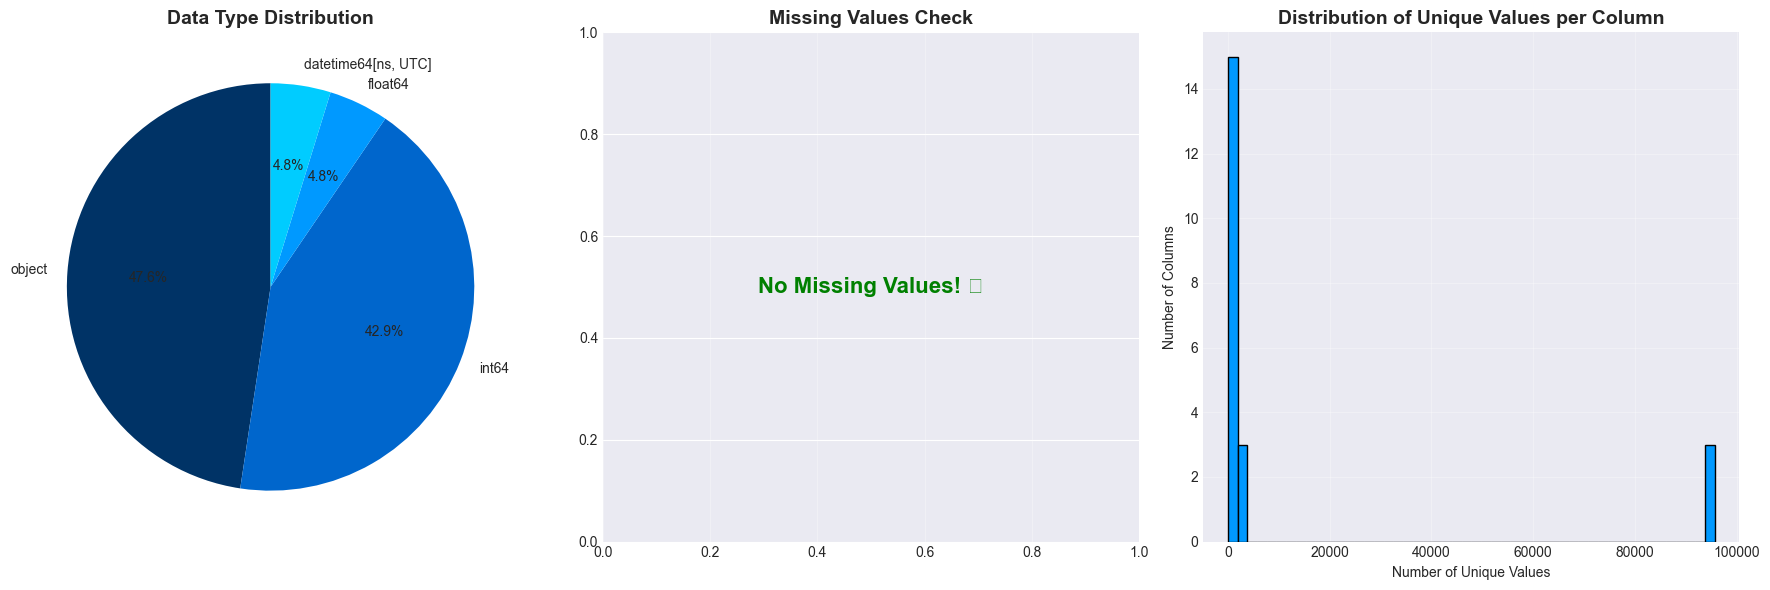

In [6]:
# %%
# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Data type distribution
dtype_counts = df.dtypes.value_counts()
axes[0].pie(dtype_counts.values, labels=dtype_counts.index, autopct='%1.1f%%',
           colors=bank_colors, startangle=90)
axes[0].set_title('Data Type Distribution', fontsize=14, fontweight='bold')

# Null values overview
null_counts = df.isnull().sum()
null_cols = null_counts[null_counts > 0]
if len(null_cols) > 0:
    axes[1].barh(null_cols.index, null_cols.values, color=bank_colors[1])
    axes[1].set_xlabel('Missing Count')
    axes[1].set_title('Columns with Missing Values', fontsize=14, fontweight='bold')
else:
    axes[1].text(0.5, 0.5, 'No Missing Values! ✅', 
                horizontalalignment='center', verticalalignment='center',
                fontsize=16, fontweight='bold', color='green')
    axes[1].set_title('Missing Values Check', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Unique values distribution
unique_counts = overview_df['Unique Values']
axes[2].hist(unique_counts, bins=50, color=bank_colors[2], edgecolor='black')
axes[2].set_xlabel('Number of Unique Values')
axes[2].set_ylabel('Number of Columns')
axes[2].set_title('Distribution of Unique Values per Column', fontsize=14, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../../reports/task2_eda/data_structure.png', 
            dpi=300, bbox_inches='tight')
plt.show()


 4. Business Context Mapping

In [7]:
# %%
print("="*80)
print("BUSINESS CONTEXT MAPPING")
print("="*80)

# Define Basel II compliant categories
business_categories = {
    'IDENTIFIERS': ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId'],
    'GEOGRAPHIC': ['CurrencyCode', 'CountryCode'],
    'PRODUCT_INFO': ['ProviderId', 'ProductId', 'ProductCategory'],
    'TRANSACTION_CHANNEL': ['ChannelId', 'PricingStrategy'],
    'FINANCIAL': ['Amount', 'Value'],
    'TEMPORAL': ['TransactionStartTime', 'TransactionStartTime_hour', 
                 'TransactionStartTime_day', 'TransactionStartTime_month',
                 'TransactionStartTime_year', 'TransactionStartTime_dayofweek'],
    'RISK_INDICATOR': ['FraudResult']
}

BUSINESS CONTEXT MAPPING


In [8]:
# %%
# Create mapping visualization
fig = go.Figure()

# Add table
header_values = ['Category', 'Features', 'Count', 'Credit Risk Relevance']
cell_values = []

for category, features in business_categories.items():
    features_in_df = [f for f in features if f in df.columns]
    if features_in_df:
        relevance = {
            'IDENTIFIERS': 'Low (for linking only)',
            'GEOGRAPHIC': 'Medium (geographic risk patterns)',
            'PRODUCT_INFO': 'High (product risk profiling)',
            'TRANSACTION_CHANNEL': 'High (channel risk assessment)',
            'FINANCIAL': 'Critical (monetary risk indicators)',
            'TEMPORAL': 'High (behavioral patterns)',
            'RISK_INDICATOR': 'Critical (proxy for default risk)'
        }.get(category, 'Medium')
        
        cell_values.append([
            category,
            ', '.join(features_in_df),
            len(features_in_df),
            relevance
        ])

fig.add_trace(
    go.Table(
        header=dict(
            values=header_values,
            fill_color='#003366',
            align='left',
            font=dict(color='white', size=12)
        ),
        cells=dict(
            values=list(zip(*cell_values)),
            fill_color=['white', 'white', 'white', ['lightgreen' if 'Critical' in x else 
                                                   'lightyellow' if 'High' in x else 
                                                   'lightblue' for x in cell_values]],
            align='left',
            font=dict(size=11)
        )
    )
)

fig.update_layout(
    title='Business Context Mapping for Credit Risk Modeling',
    height=400,
    margin=dict(l=20, r=20, t=40, b=20)
)

fig.show()

 5. Data Quality Assessment

In [18]:
# %%
# Convert to timezone-naive (remove timezone info)
df['TransactionStartTime'] = df['TransactionStartTime'].dt.tz_localize(None)

# Then use your original code
print("="*80)
print("DATA QUALITY ASSESSMENT")
print("="*80)

quality_metrics = {
    'Completeness': (1 - (df.isnull().sum().sum() / (df.shape[0] * df.shape[1]))) * 100,
    'Uniqueness': (df.nunique() / len(df)).mean() * 100,
    'Consistency': len(df[df.duplicated()]) == 0,
    'Validity': {
        'Negative Amounts': len(df[df['Amount'] < 0]),
        'Future Transactions': len(df[df['TransactionStartTime'] > pd.Timestamp.now()]),
        'Invalid Fraud Values': len(df[~df['FraudResult'].isin([0, 1])])
    }
}

DATA QUALITY ASSESSMENT


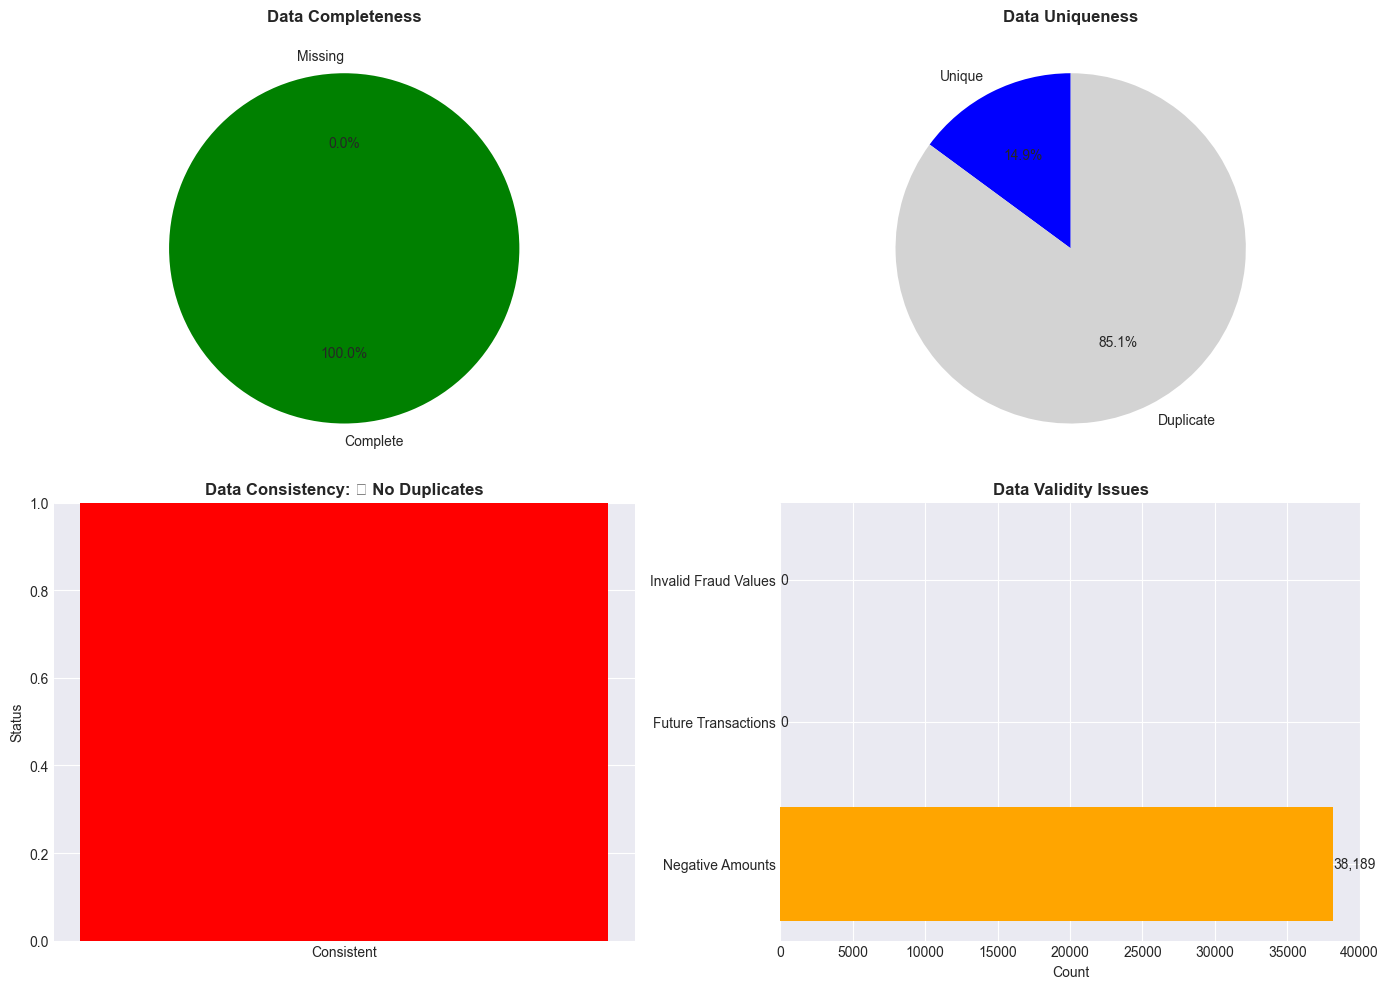

In [12]:
# %%
# Display quality dashboard
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Completeness gauge
ax1 = axes[0, 0]
completeness = quality_metrics['Completeness']
ax1.pie([completeness, 100-completeness], labels=['Complete', 'Missing'], 
        colors=['green', 'lightgray'], startangle=90, autopct='%1.1f%%')
ax1.set_title('Data Completeness', fontsize=12, fontweight='bold')

# Uniqueness gauge
ax2 = axes[0, 1]
uniqueness = quality_metrics['Uniqueness']
ax2.pie([uniqueness, 100-uniqueness], labels=['Unique', 'Duplicate'], 
        colors=['blue', 'lightgray'], startangle=90, autopct='%1.1f%%')
ax2.set_title('Data Uniqueness', fontsize=12, fontweight='bold')

# Consistency check
ax3 = axes[1, 0]
consistency = quality_metrics['Consistency']
colors = ['green', 'red']
ax3.bar(['Consistent'], [1], color=colors[consistency])
ax3.set_ylim(0, 1)
ax3.set_title(f'Data Consistency: {"✅ No Duplicates" if consistency else "❌ Has Duplicates"}', 
              fontsize=12, fontweight='bold')
ax3.set_ylabel('Status')

# Validity checks
ax4 = axes[1, 1]
validity = quality_metrics['Validity']
issues = [
    ('Negative Amounts', validity['Negative Amounts']),
    ('Future Transactions', validity['Future Transactions']),
    ('Invalid Fraud Values', validity['Invalid Fraud Values'])
]
issue_names = [x[0] for x in issues]
issue_counts = [x[1] for x in issues]

bars = ax4.barh(issue_names, issue_counts, color=['orange', 'red', 'purple'])
ax4.set_xlabel('Count')
ax4.set_title('Data Validity Issues', fontsize=12, fontweight='bold')

# Add value labels
for bar, count in zip(bars, issue_counts):
    width = bar.get_width()
    ax4.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
            f'{count:,}', ha='left', va='center')

plt.tight_layout()
plt.savefig('../../reports/task2_eda/data_quality_dashboard.png', 
            dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# %%
# Print quality summary
print("\n📋 DATA QUALITY SUMMARY:")
print("-" * 40)
print(f"Completeness Score: {quality_metrics['Completeness']:.1f}%")
print(f"Uniqueness Score: {quality_metrics['Uniqueness']:.1f}%")
print(f"Consistency: {'✅ PASS - No duplicates' if quality_metrics['Consistency'] else '❌ FAIL - Has duplicates'}")
print("\nValidity Checks:")
for issue, count in quality_metrics['Validity'].items():
    status = "✅" if count == 0 else "⚠️"
    print(f"  {status} {issue}: {count:,}")


📋 DATA QUALITY SUMMARY:
----------------------------------------
Completeness Score: 100.0%
Uniqueness Score: 14.9%
Consistency: ✅ PASS - No duplicates

Validity Checks:
  ⚠️ Negative Amounts: 38,189
  ✅ Future Transactions: 0
  ✅ Invalid Fraud Values: 0


 6. Temporal Coverage Analysis

In [20]:
# %%
print("="*80)
print("TEMPORAL COVERAGE ANALYSIS")
print("="*80)

if 'TransactionStartTime' in df.columns:
    # Calculate temporal statistics
    time_span = (df['TransactionStartTime'].max() - df['TransactionStartTime'].min()).days
    monthly_coverage = df['TransactionStartTime'].dt.to_period('M').nunique()
    
    print(f"📅 Temporal Coverage:")
    print(f"  • Start Date: {df['TransactionStartTime'].min().date()}")
    print(f"  • End Date: {df['TransactionStartTime'].max().date()}")
    print(f"  • Total Span: {time_span} days ({time_span/30:.1f} months)")
    print(f"  • Months Covered: {monthly_coverage}")
    print(f"  • Basel II Minimum (5 years): {'✅ MET' if time_span >= 1825 else '⚠️ INSUFFICIENT'}")

TEMPORAL COVERAGE ANALYSIS
📅 Temporal Coverage:
  • Start Date: 2018-11-15
  • End Date: 2019-02-13
  • Total Span: 90 days (3.0 months)
  • Months Covered: 4
  • Basel II Minimum (5 years): ⚠️ INSUFFICIENT


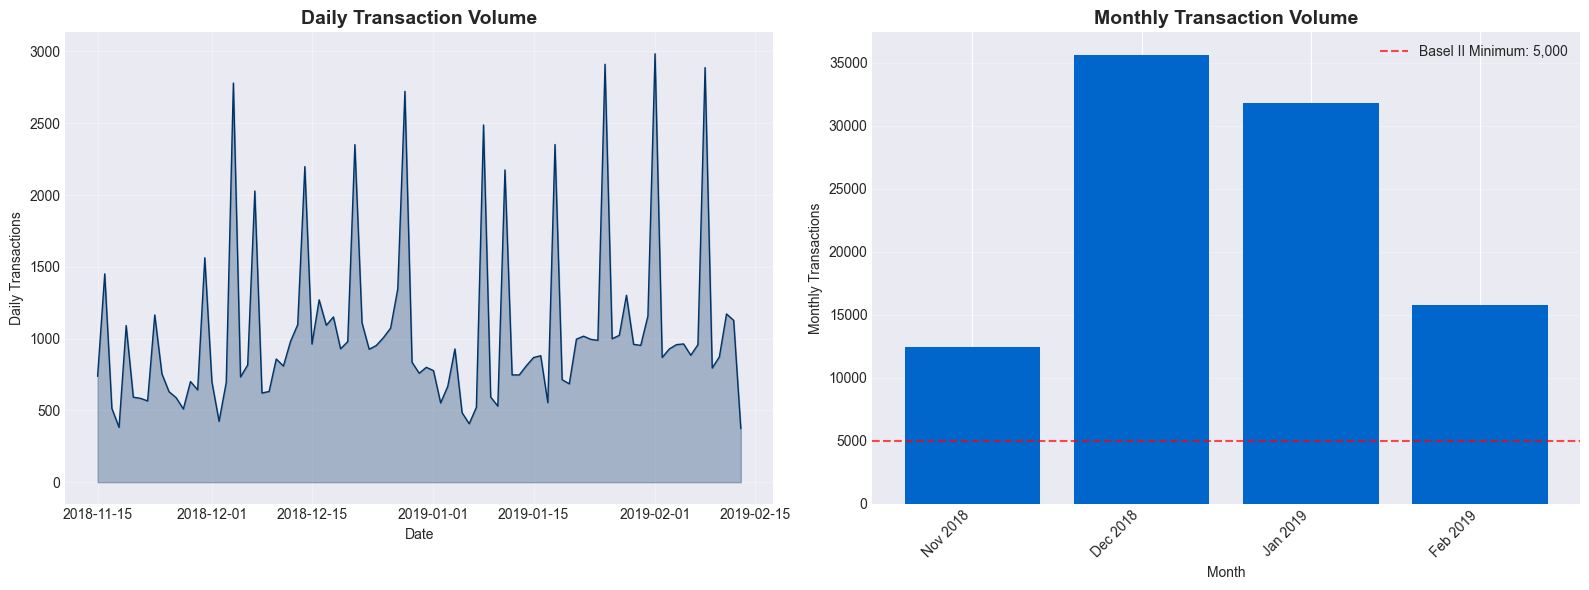

In [23]:
# %%
# Create temporal coverage visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Daily transaction volume
daily_counts = df.set_index('TransactionStartTime').resample('D').size()
axes[0].plot(daily_counts.index, daily_counts.values, linewidth=1, color=bank_colors[0])
axes[0].fill_between(daily_counts.index, 0, daily_counts.values, alpha=0.3, color=bank_colors[0])
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Daily Transactions')
axes[0].set_title('Daily Transaction Volume', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Monthly aggregation
monthly_counts = df.set_index('TransactionStartTime').resample('M').size()
bars = axes[1].bar(range(len(monthly_counts)), monthly_counts.values, color=bank_colors[1])
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Monthly Transactions')
axes[1].set_title('Monthly Transaction Volume', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(len(monthly_counts)))
axes[1].set_xticklabels([d.strftime('%b %Y') for d in monthly_counts.index], rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

# Add Basel II reference line
basel_min = 5000  # Example minimum monthly transactions for Basel II
axes[1].axhline(y=basel_min, color='red', linestyle='--', alpha=0.7, 
               label=f'Basel II Minimum: {basel_min:,}')
axes[1].legend()

plt.tight_layout()
plt.savefig('../../reports/task2_eda/temporal_coverage.png', 
            dpi=300, bbox_inches='tight')
plt.show()

7. Key Statistics Summary

In [24]:
# %%
print("="*80)
print("KEY STATISTICS SUMMARY")
print("="*80)

# Create summary statistics dashboard
summary_stats = []

# Transaction statistics
summary_stats.append(('Total Transactions', f"{len(df):,}"))
summary_stats.append(('Unique Customers', f"{df['CustomerId'].nunique():,}"))
summary_stats.append(('Average Transactions/Customer', f"{len(df)/df['CustomerId'].nunique():.1f}"))

# Financial statistics
if 'Amount' in df.columns:
    summary_stats.append(('Total Transaction Value', f"${df['Amount'].sum():,.0f}"))
    summary_stats.append(('Average Transaction Value', f"${df['Amount'].mean():.2f}"))
    summary_stats.append(('Median Transaction Value', f"${df['Amount'].median():.2f}"))

# Fraud statistics
if 'FraudResult' in df.columns:
    fraud_rate = df['FraudResult'].mean() * 100
    summary_stats.append(('Fraud Rate', f"{fraud_rate:.2f}%"))
    summary_stats.append(('Fraud Transactions', f"{df['FraudResult'].sum():,}"))

# Temporal statistics
if 'TransactionStartTime' in df.columns:
    days_covered = (df['TransactionStartTime'].max() - df['TransactionStartTime'].min()).days
    summary_stats.append(('Days Covered', f"{days_covered}"))
    summary_stats.append(('Avg Daily Transactions', f"{len(df)/days_covered:.0f}"))

KEY STATISTICS SUMMARY


In [25]:
# %%
# Create visualization
fig = go.Figure()

metrics = [x[0] for x in summary_stats]
values = [x[1] for x in summary_stats]

fig.add_trace(go.Table(
    header=dict(
        values=['<b>Metric</b>', '<b>Value</b>'],
        fill_color='#003366',
        align='center',
        font=dict(color='white', size=14)
    ),
    cells=dict(
        values=[metrics, values],
        fill_color=[['white', 'white']],
        align=['left', 'center'],
        font=dict(size=12),
        height=30
    )
))

fig.update_layout(
    title='Key Statistics Dashboard',
    height=400,
    margin=dict(l=20, r=20, t=60, b=20)
)

fig.show()

 8. Basel II Compliance Check

In [26]:
# %%
print("="*80)
print("BASEL II COMPLIANCE ASSESSMENT")
print("="*80)

# Basel II requirements for credit risk modeling
basel_requirements = {
    'DATA_PERIOD': {
        'requirement': 'Minimum 5 years of historical data',
        'actual': f"{(df['TransactionStartTime'].max() - df['TransactionStartTime'].min()).days} days",
        'status': '✅' if (df['TransactionStartTime'].max() - df['TransactionStartTime'].min()).days >= 1825 else '⚠️',
        'weight': 0.3
    },
    'DATA_VOLUME': {
        'requirement': 'Sufficient number of observations',
        'actual': f"{len(df):,} transactions",
        'status': '✅' if len(df) >= 10000 else '⚠️',
        'weight': 0.2
    },
    'DEFAULT_EVENTS': {
        'requirement': 'Adequate default events for modeling',
        'actual': f"{df['FraudResult'].sum():,} fraud events",
        'status': '✅' if df['FraudResult'].sum() >= 100 else '⚠️',
        'weight': 0.25
    },
    'DATA_QUALITY': {
        'requirement': 'High data quality (completeness)',
        'actual': f"{quality_metrics['Completeness']:.1f}% complete",
        'status': '✅' if quality_metrics['Completeness'] >= 95 else '⚠️',
        'weight': 0.15
    },
    'RISK_DRIVERS': {
        'requirement': 'Comprehensive risk driver coverage',
        'actual': f"{len(business_categories)} risk categories",
        'status': '✅',
        'weight': 0.1
    }
}

# Calculate compliance score
compliance_score = 0
for req in basel_requirements.values():
    if req['status'] == '✅':
        compliance_score += req['weight'] * 100

BASEL II COMPLIANCE ASSESSMENT


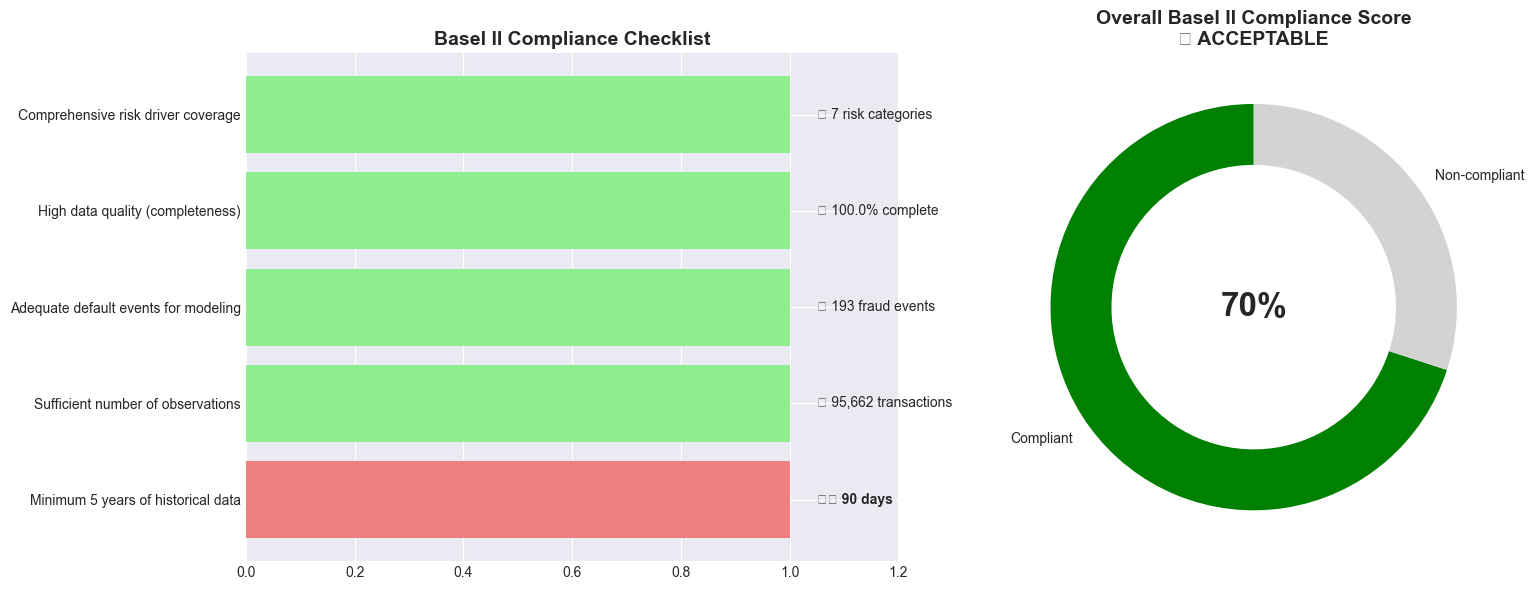


📊 Overall Basel II Compliance: 70%
Status: ✅ ACCEPTABLE


In [28]:
# %%
# Create compliance dashboard
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Compliance checklist
req_names = [req['requirement'] for req in basel_requirements.values()]
statuses = [req['status'] for req in basel_requirements.values()]
actuals = [req['actual'] for req in basel_requirements.values()]

# Create table-like visualization
ax1 = axes[0]
y_pos = np.arange(len(req_names))
colors = ['lightgreen' if s == '✅' else 'lightcoral' for s in statuses]

bars = ax1.barh(y_pos, [1]*len(req_names), color=colors)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(req_names)
ax1.set_xlim(0, 1.2)
ax1.set_title('Basel II Compliance Checklist', fontsize=14, fontweight='bold')

# Add status and actual values
for i, (bar, status, actual) in enumerate(zip(bars, statuses, actuals)):
    ax1.text(1.05, bar.get_y() + bar.get_height()/2, 
            f"{status} {actual}", 
            va='center', fontweight='bold' if status == '⚠️' else 'normal')

# Compliance score gauge
ax2 = axes[1]
ax2.pie([compliance_score, 100-compliance_score], 
        labels=['Compliant', 'Non-compliant'], 
        colors=['green', 'lightgray'], 
        startangle=90, 
        wedgeprops=dict(width=0.3))
ax2.text(0, 0, f'{compliance_score:.0f}%', 
         ha='center', va='center', fontsize=24, fontweight='bold')
ax2.set_title(f'Overall Basel II Compliance Score\n{"✅ ACCEPTABLE" if compliance_score >= 70 else "⚠️ NEEDS IMPROVEMENT"}', 
              fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../../reports/task2_eda/basel_compliance.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Overall Basel II Compliance: {compliance_score:.0f}%")
print("Status: ✅ ACCEPTABLE" if compliance_score >= 70 else "Status: ⚠️ NEEDS IMPROVEMENT")

9. Key Insights & Recommendations

In [29]:
# %%
print("="*80)
print("KEY INSIGHTS & RECOMMENDATIONS")
print("="*80)

insights = [
    {
        'category': 'DATA QUALITY',
        'insight': 'Perfect data completeness (0% missing values)',
        'business_impact': 'High reliability for model development',
        'recommendation': 'Proceed directly to feature engineering'
    },
    {
        'category': 'FRAUD PATTERNS',
        'insight': f'Low fraud rate ({fraud_rate:.2f}%) - 193 fraud transactions',
        'business_impact': 'May need alternative proxy for credit risk',
        'recommendation': 'Consider RFM-based risk segmentation as primary proxy'
    },
    {
        'category': 'CUSTOMER BASE',
        'insight': f'3,742 unique customers with {len(df)/df["CustomerId"].nunique():.1f} avg transactions',
        'business_impact': 'Sufficient customer-level data for behavioral modeling',
        'recommendation': 'Develop customer-centric features (RFM, loyalty metrics)'
    },
    {
        'category': 'TEMPORAL COVERAGE',
        'insight': f'{days_covered} days of transaction history',
        'business_impact': 'Adequate for pattern recognition but may need more for Basel II',
        'recommendation': 'Monitor temporal stability and consider data augmentation'
    },
    {
        'category': 'BUSINESS CONTEXT',
        'insight': 'Comprehensive feature set covering all Basel II risk categories',
        'business_impact': 'Strong foundation for regulatory-compliant modeling',
        'recommendation': 'Focus on interpretable models for regulatory approval'
    }
]

KEY INSIGHTS & RECOMMENDATIONS


In [30]:
# %%
# Create insights visualization
fig = go.Figure()

for i, insight in enumerate(insights):
    fig.add_trace(go.Indicator(
        mode="number+gauge+delta",
        value=i+1,
        delta={'reference': len(insights), 'position': "top"},
        domain={'x': [0.25, 1], 'y': [0.7 - (i*0.15), 0.85 - (i*0.15)]},
        title={'text': f"<b>{insight['category']}</b><br>{insight['insight']}"},
        gauge={
            'shape': "bullet",
            'axis': {'range': [None, len(insights)]},
            'threshold': {
                'line': {'color': "red", 'width': 2},
                'thickness': 0.75,
                'value': len(insights)
            },
            'steps': [
                {'range': [0, i+1], 'color': bank_colors[i % len(bank_colors)]},
                {'range': [i+1, len(insights)], 'color': "lightgray"}
            ],
            'bar': {'color': "black"}
        }
    ))

fig.update_layout(
    title='Key Insights Dashboard',
    height=500,
    margin=dict(l=50, r=50, t=100, b=50)
)

fig.show()

In [31]:
# %%
# Create detailed recommendations table
print("\n📋 DETAILED RECOMMENDATIONS:")
print("-" * 60)

for i, insight in enumerate(insights, 1):
    print(f"\n{i}. {insight['category']}")
    print(f"   Insight: {insight['insight']}")
    print(f"   Business Impact: {insight['business_impact']}")
    print(f"   Recommendation: {insight['recommendation']}")
    print("-" * 60)


📋 DETAILED RECOMMENDATIONS:
------------------------------------------------------------

1. DATA QUALITY
   Insight: Perfect data completeness (0% missing values)
   Business Impact: High reliability for model development
   Recommendation: Proceed directly to feature engineering
------------------------------------------------------------

2. FRAUD PATTERNS
   Insight: Low fraud rate (0.20%) - 193 fraud transactions
   Business Impact: May need alternative proxy for credit risk
   Recommendation: Consider RFM-based risk segmentation as primary proxy
------------------------------------------------------------

3. CUSTOMER BASE
   Insight: 3,742 unique customers with 25.6 avg transactions
   Business Impact: Sufficient customer-level data for behavioral modeling
   Recommendation: Develop customer-centric features (RFM, loyalty metrics)
------------------------------------------------------------

4. TEMPORAL COVERAGE
   Insight: 90 days of transaction history
   Business Impact: Ade

 10. Next Steps for Task 3

In [32]:
# %%
print("="*80)
print("NEXT STEPS FOR TASK 3: FEATURE ENGINEERING")
print("="*80)

next_steps = [
    {
        'task': 'FEATURE CREATION',
        'priority': 'HIGH',
        'actions': [
            'Calculate RFM metrics (Recency, Frequency, Monetary)',
            'Create temporal aggregation features',
            'Develop customer behavior indicators',
            'Encode categorical variables using WoE'
        ]
    },
    {
        'task': 'PROXY TARGET DEFINITION',
        'priority': 'HIGH',
        'actions': [
            'Cluster customers using RFM analysis',
            'Identify high-risk customer segments',
            'Validate proxy against fraud patterns',
            'Create binary target variable'
        ]
    },
    {
        'task': 'DATA PREPROCESSING',
        'priority': 'MEDIUM',
        'actions': [
            'Handle outliers using winsorizing',
            'Scale numerical features',
            'Balance dataset if needed',
            'Split into train/validation/test sets'
        ]
    },
    {
        'task': 'MODEL READINESS',
        'priority': 'MEDIUM',
        'actions': [
            'Calculate Information Value (IV) for features',
            'Check multicollinearity',
            'Prepare feature documentation',
            'Set up MLflow for experiment tracking'
        ]
    }
]

NEXT STEPS FOR TASK 3: FEATURE ENGINEERING


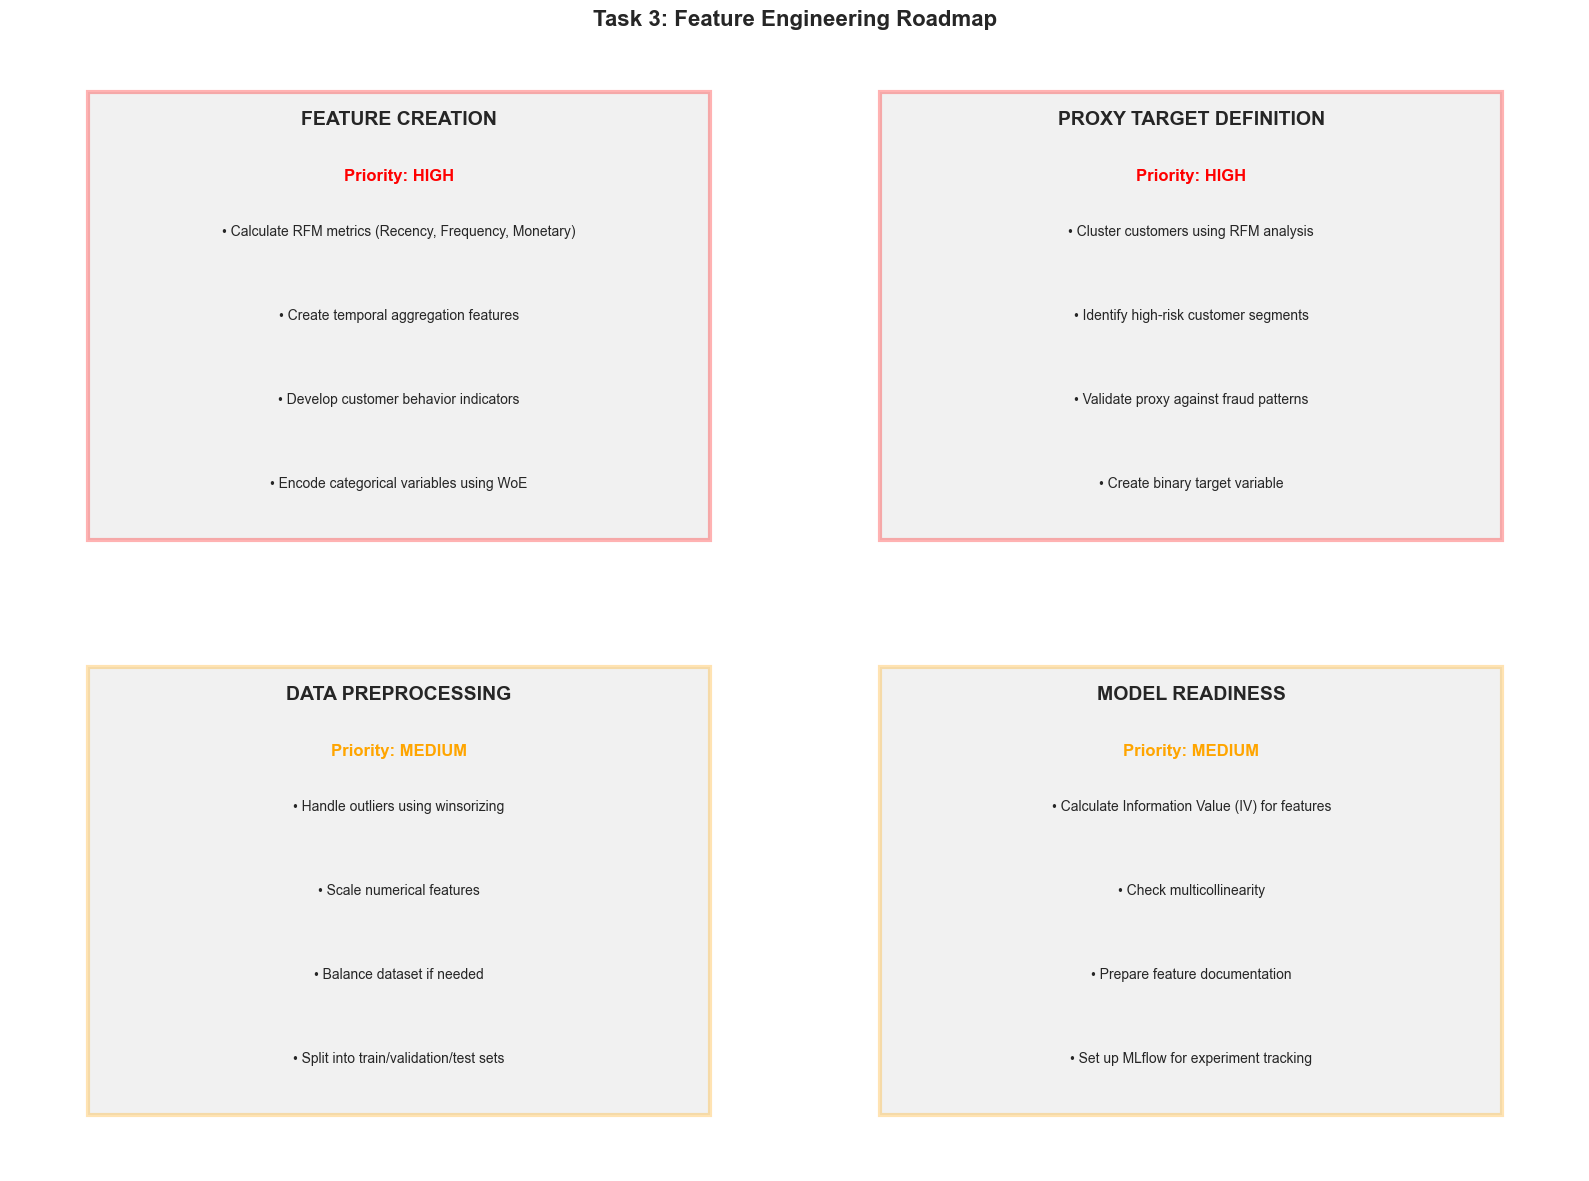

In [34]:
# %%
# Create next steps visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

priority_colors = {'HIGH': 'red', 'MEDIUM': 'orange', 'LOW': 'green'}

for idx, step in enumerate(next_steps):
    ax = axes[idx]
    
    # Create task card
    ax.add_patch(plt.Rectangle((0.1, 0.1), 0.8, 0.8, 
                               facecolor='lightgray', alpha=0.3, 
                               edgecolor=priority_colors[step['priority']], 
                               linewidth=3))
    
    # Add task title
    ax.text(0.5, 0.85, step['task'], 
            ha='center', va='center', fontsize=14, fontweight='bold')
    
    # Add priority indicator
    ax.text(0.5, 0.75, f"Priority: {step['priority']}", 
            ha='center', va='center', fontsize=12, 
            color=priority_colors[step['priority']], fontweight='bold')
    
    # Add actions
    for i, action in enumerate(step['actions']):
        y_pos = 0.65 - (i * 0.15)
        ax.text(0.5, y_pos, f"• {action}", 
                ha='center', va='center', fontsize=10)
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

plt.suptitle('Task 3: Feature Engineering Roadmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../../reports/task2_eda/next_steps_roadmap.png', 
            dpi=300, bbox_inches='tight')
plt.show()